In [15]:
import numpy as np
import torch
%matplotlib inline
from matplotlib import pyplot as plt
import tqdm
import torch.nn.functional as F
import torch.nn as nn
import pickle
import fb_utils as fb

In [16]:
# choose the target filterbank

target = "CQT"
#target = "MEL"
#target = "VQT"

In [17]:
# load hyperparameters

spec = fb.HYPERPARAMS[target]

In [18]:
# load the info about the target fb as dictionaries, containing:
#   "freqz" frequency responses as 2D array (time,channels)
#   "centerfreq" 
#   "bandwidths"
#   "framebounds" computed without subsampling

with open('targets/'+target+'.pkl', 'rb') as fp:
    FB = pickle.load(fp)

FB_freq = FB["freqz"]
FB_torch = torch.from_numpy(FB_freq.T)
FB_torch.shape

torch.Size([58, 4092])

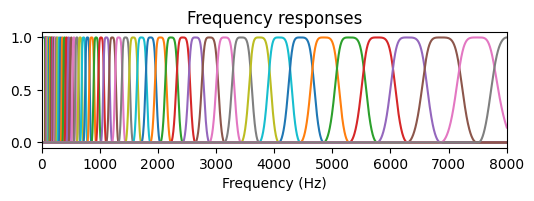

In [19]:
# plot the frequency responses of the target fb

fig = plt.figure(figsize=(6, 1.5))

omega = np.linspace(0, spec["sr"], FB_freq.shape[0])
plt.plot(omega, FB_freq/ np.max(FB_freq, axis=0));
plt.title("Frequency responses")
plt.xlim(0, spec["sr"]//2+1)
plt.xlabel("Frequency (Hz)");

In [20]:
# initialize filters

w_init = fb.random_filterbank(spec["N"], spec["J"], spec["T"], tight=False, to_torch=True, support_only=True)
np.save('values/'+target+'_w_init.npy', w_init)

In [21]:
# initialize data generator

synth = fb.generate_random_sine(
    spec["sr"],
    spec["fmin"],
    spec["fmax"],
    spec["N"],
    spec["batch_size"])

In [22]:
# conv1D layer with circulant boundary conditions and pooling

class TDFilterbank(torch.nn.Module):
    def __init__(self, spec, w):
        super().__init__()
        
        self.psi = torch.nn.Conv1d(
            in_channels=1,
            out_channels=spec["J"],
            kernel_size=spec["T"],
            stride=spec["stride"],
            padding=0,
            bias=False)

        self.psi.weight.data = w[:, :spec["T"]].unsqueeze(1).float()        
    
    def forward(self, x):
        x = x.reshape(x.shape[0], 1, x.shape[-1])
        x = F.pad(x, (0, spec["T"]-1), mode='circular',)
        Wx = torch.abs(self.psi(x))
        hann = torch.hann_window(spec["N"]//spec["stride"]).unsqueeze(0).unsqueeze(0)
        phi = torch.ones(spec["J"], spec["J"], spec["N"]//spec["stride"])*hann
        Ux = F.conv1d(Wx, phi, bias=None, stride=1, padding=0)
        return Ux
    
baseline = TDFilterbank(spec, w_init)
print(baseline)

TDFilterbank(
  (psi): Conv1d(1, 58, kernel_size=(1024,), stride=(341,), bias=False)
)


In [23]:
# check output sizes

print('filterbank:', fb.filterbank_response_fft(next(synth), FB_torch, spec).shape)
print('convnet:', baseline(next(synth)).shape)

filterbank: torch.Size([64, 58, 1])
convnet: torch.Size([64, 58, 1])


In [24]:
# loss function penalizing cosine similarity and kappa

class KappaLoss(nn.Module):
    def __init__(self):
        super(KappaLoss, self).__init__()
        self.loss = nn.CosineSimilarity(dim=0)

    def forward(self, inputs, targets, w, beta):
        w_hat = torch.sum(torch.abs(torch.fft.fft(w,dim=1))**2,dim=0)
        B = torch.max(w_hat,dim=0).values
        A = torch.min(w_hat,dim=0).values
        loss = 0.5*torch.mean(1-self.loss(inputs, targets)) + beta*B/A
        return loss

In [25]:
# training function

def train(baseline, penalization, lr, beta, n_epochs, epoch_size):
    optimizer = torch.optim.Adam(baseline.parameters(), lr=lr)
    cos = torch.nn.CosineSimilarity(dim=0)
    criterion = KappaLoss()
    if penalization == 'cos':
        beta=0
    if penalization == 'kappa':
        beta=beta
    losses = []
    conditions = []

    running_loss = 0.0
    for _ in range(epoch_size):
        inputs = next(synth)
        outputs = baseline(inputs)
        targets = fb.filterbank_response_fft(inputs, FB_torch, spec)
        loss = 0.5*torch.mean(1-cos(outputs, targets))
        running_loss += loss.item()
    print(1000 * running_loss)

    w = baseline.psi.weight.detach().numpy()[:,0,:]
    w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
    A,B = fb.frame_bounds_lp(w)
    conditions.append(B/A)
    
    losses.append(running_loss)

    for _ in range(n_epochs):
        running_loss = 0.0
        for i in tqdm.tqdm(range(epoch_size)):
            inputs = next(synth)
            optimizer.zero_grad()
            outputs = baseline(inputs)
            targets = fb.filterbank_response_fft(inputs, FB_torch, spec)

            w = baseline.psi.weight[:,0,:]
            w = F.pad(w,(0,spec["N"]-spec["T"]), value=0)
            loss = criterion(outputs, targets, w, beta)

            loss.backward()
            optimizer.step()

            loss2 = 0.5*torch.mean(1-cos(outputs, targets))
            running_loss += loss2.item()
        losses.append(running_loss)

        w = baseline.psi.weight.detach().numpy()[:,0,:]
        w = np.pad(w, ((0,0),(0, spec["N"]-spec["T"])), constant_values=0)
        A,B = fb.frame_bounds_lp(w)
        conditions.append(B/A)

        print(1000 * running_loss)

    return losses, conditions

In [26]:
# training hyperparameters

n_epochs = 50
epoch_size = 100
lr = 1e-6
if target == 'CQT':
    beta = 0.00001
if target == 'MEL':
    beta = 0.0001
if target == 'VQT':
    beta = 0.0005

In [27]:
# train: no penalization

baseline_no = TDFilterbank(spec, w_init)
losses_no, conditions_no = train(
    baseline=baseline_no,
    penalization='cos',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_no = baseline_no.psi.weight.detach().numpy()[:,0,:]
np.save('values/'+target+'_losses_no.npy', losses_no)
np.save('values/'+target+'_conditions_no.npy', conditions_no)
np.save('values/'+target+'_w_no.npy', w_no)

631.4028296619654


100%|██████████| 100/100 [00:10<00:00,  9.89it/s]


558.7916006334126


100%|██████████| 100/100 [00:10<00:00,  9.86it/s]


441.74132496118546


100%|██████████| 100/100 [00:10<00:00,  9.96it/s]


384.6691909711808


100%|██████████| 100/100 [00:10<00:00,  9.92it/s]


355.4254120681435


100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


322.9843978770077


100%|██████████| 100/100 [00:09<00:00, 10.06it/s]


306.51298887096345


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


282.0480471709743


100%|██████████| 100/100 [00:09<00:00, 10.11it/s]


260.11008385103196


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


240.13142206240445


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


228.16886007785797


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


217.59643719997257


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


202.9160838574171


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


192.73072527721524


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


176.73008691053838


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


179.00556756649166


100%|██████████| 100/100 [00:09<00:00, 10.10it/s]


167.61300200596452


100%|██████████| 100/100 [00:09<00:00, 10.13it/s]


162.89752419106662


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


149.48545093648136


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


145.87258989922702


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


143.92572356155142


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


132.64290889492258


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


135.13012661132962


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


131.24140253057703


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


123.70847631245852


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


118.49729088135064


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


116.00486922543496


100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


110.05056684371084


100%|██████████| 100/100 [00:10<00:00,  9.87it/s]


105.03680864349008


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


104.26554799778387


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


99.13619211874902


100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


92.98595492145978


100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


96.89591242931783


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


97.90119959507138


100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


93.3053782209754


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


97.27373273926787


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


84.17024501250125


100%|██████████| 100/100 [00:09<00:00, 10.14it/s]


84.12592875538394


100%|██████████| 100/100 [00:10<00:00,  9.15it/s]


82.15489861322567


100%|██████████| 100/100 [00:10<00:00,  9.93it/s]


82.31575321406126


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


78.31354578956962


100%|██████████| 100/100 [00:10<00:00,  9.44it/s]


80.21471393294632


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


78.07969945133664


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


78.15064032911323


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


66.29413561313413


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


70.45675677363761


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


70.34483744064346


100%|██████████| 100/100 [00:09<00:00, 10.18it/s]


66.35645349160768


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


67.55887434701435


100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


66.98254478396848


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]

65.13144206837751


In [28]:
# train: kappa penalization

baseline_kappa = TDFilterbank(spec, w_init)
losses_kappa, conditions_kappa = train(
    baseline=baseline_kappa,
    penalization='kappa',
    lr=lr,
    beta=beta,
    n_epochs=n_epochs,
    epoch_size=epoch_size)

w_kappa = baseline_kappa.psi.weight.detach().numpy()[:,0,:]
np.save('values/'+target+'_losses_kappa.npy', losses_kappa)
np.save('values/'+target+'_conditions_kappa.npy', conditions_kappa)
np.save('values/'+target+'_w_kappa.npy', w_kappa)

629.8442836850882


100%|██████████| 100/100 [00:09<00:00, 10.31it/s]


551.1899096891284


100%|██████████| 100/100 [00:09<00:00, 10.12it/s]


454.21997737139463


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


388.42615904286504


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


348.71662920340896


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


325.63969888724387


100%|██████████| 100/100 [00:09<00:00, 10.28it/s]


303.22546255774796


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


273.7929319264367


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


261.1627388978377


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


242.57847957778722


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


226.6934335930273


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


209.1107820160687


100%|██████████| 100/100 [00:09<00:00, 10.30it/s]


207.15012191794813


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


191.95195415522903


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


171.95118451490998


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


168.34991879295558


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


159.59451696835458


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


157.58899942738935


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


156.82587632909417


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


143.6474707443267


100%|██████████| 100/100 [00:09<00:00, 10.36it/s]


134.2283376143314


100%|██████████| 100/100 [00:09<00:00, 10.07it/s]


134.22441319562495


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


134.58960957359523


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


130.3940021316521


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


115.21269247168675


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


112.8831462119706


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


117.51503922278062


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


116.5028975228779


100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


109.11118047079071


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


103.68530586129054


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


98.89206613297574


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


94.91672686999664


100%|██████████| 100/100 [00:09<00:00, 10.40it/s]


97.93704704497941


100%|██████████| 100/100 [00:09<00:00, 10.26it/s]


91.44353691954166


100%|██████████| 100/100 [00:09<00:00, 10.41it/s]


95.81470637931488


100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


94.66520845307969


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


86.01968255243264


100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


87.33009584830143


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


82.49856549082324


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


80.80578071530908


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


84.57098741200753


100%|██████████| 100/100 [00:09<00:00, 10.38it/s]


76.69640498352237


100%|██████████| 100/100 [00:09<00:00, 10.37it/s]


74.49888050905429


100%|██████████| 100/100 [00:09<00:00, 10.16it/s]


72.13553483597934


100%|██████████| 100/100 [00:09<00:00, 10.23it/s]


70.6046469276771


100%|██████████| 100/100 [00:09<00:00, 10.25it/s]


72.74331519147381


100%|██████████| 100/100 [00:09<00:00, 10.32it/s]


69.75934337242506


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


66.7535065440461


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]


66.84822379611433


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


69.40837559523061


100%|██████████| 100/100 [00:09<00:00, 10.35it/s]

61.45868735620752


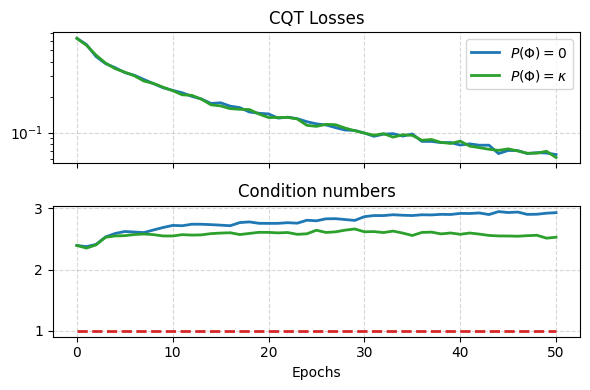

In [29]:
# plot losses and condition numbers over epochs

plt.rcParams['text.usetex'] = False

fig, axes = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
Ts = np.arange(0, n_epochs+1)

ax = axes[0]
ax.plot(Ts, losses_no, 'tab:blue', linewidth=2, label='$P(\Phi)=0$')
ax.plot(Ts, losses_kappa, 'tab:green', linewidth=2, label='$P(\Phi)=\kappa$')

ax.set_yscale('log')
ax.set_title(target+' Losses')
ax.grid(linestyle='--', alpha=0.5)

ax = axes[1]
ax.plot(Ts, conditions_no, 'tab:blue', linewidth=2)
ax.plot(Ts, conditions_kappa, 'tab:green', linewidth=2)
ax.plot(Ts, np.ones(len(Ts)), 'tab:red', linewidth=2, label='Tightened', linestyle='--')

ax.set_title('Condition numbers')
ax.set_xlabel('Epochs')
axes[0].legend(loc='upper right')
ax.grid(linestyle='--', alpha=0.5)

plt.tight_layout()

plt.savefig('Fitting_'+target+'.pdf', bbox_inches='tight')